# 05: Unsupervised Learning & Anomaly Detection

This notebook explores clustering and anomaly detection in network behavior.

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
from src.telecom_qoe_analytics.data_loader import get_merged_dataset, setup_plotting, get_numeric_features

setup_plotting(context="paper", palette="deep", style="ticks")
df = get_merged_dataset()

📈 Plotting environment set: style=ticks, palette=deep, context=paper


## 1. Time Series Decomposition (STL)

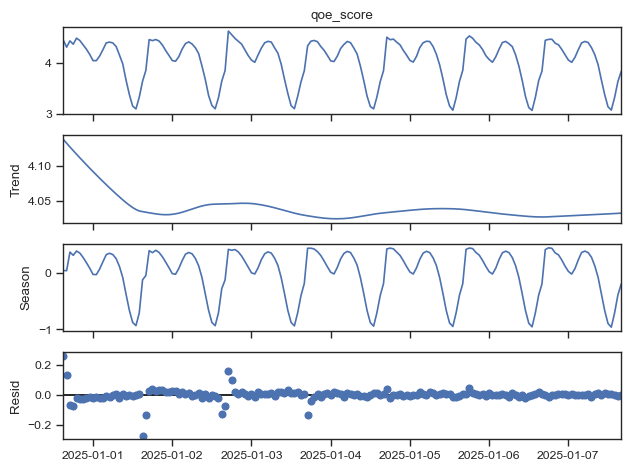

In [2]:
hourly_data = df.set_index("timestamp_start")["qoe_score"].resample("h").mean().ffill()
res = STL(hourly_data, period=24).fit()
fig = res.plot()
plt.show()

### 💡 How to read this: Time Series Decomposition
* **Trend:** Is the network performance generally getting better or worse over weeks/months?
* **Seasonal:** The predictable daily heart-beat (high at noon, low at midnight).
* **Residual (Irreg):** This is where the **anomalies** hide. It's the performance changes that CANNOT be explained by the trend or the time of day.


## 2. Anomaly Detection (Isolation Forest)

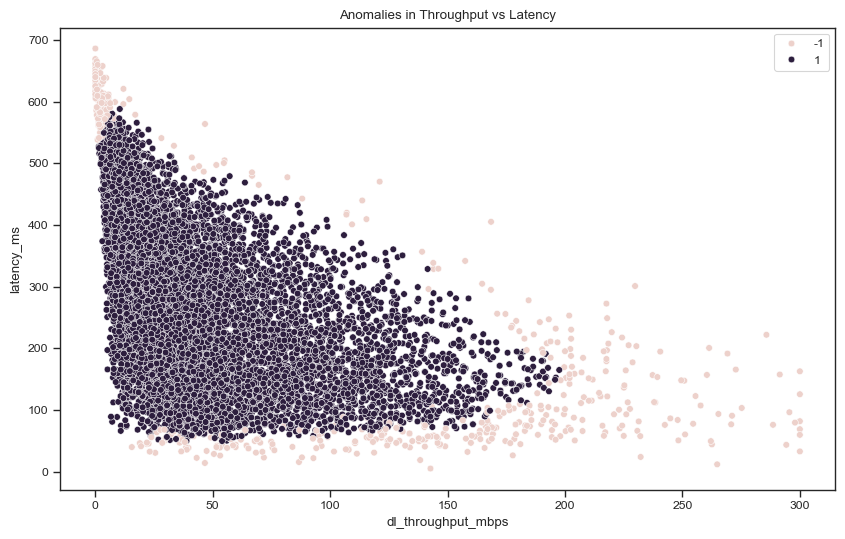

In [3]:
numeric_cols = ["dl_throughput_mbps", "latency_ms", "utilization_pct_hourly"]
X = df[numeric_cols].sample(10000, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = IsolationForest(contamination=0.05, random_state=42)
anomalies = model.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X["dl_throughput_mbps"], y=X["latency_ms"], hue=anomalies)
plt.title("Anomalies in Throughput vs Latency")
plt.show()

### 💡 How to read this: Anomaly Scatter
* **Normal (1):** Where the vast majority of data points sit.
* **Anomaly (-1):** Points that are statistically "far away." 
* **What to look for:** Look for users with *high* throughput but *high* latency—these are strange cases that standard network rules might not explain.


## 3. Time Series Anomaly Visualization

Plotting `qoe_score` over time, highlighting detected anomalies.

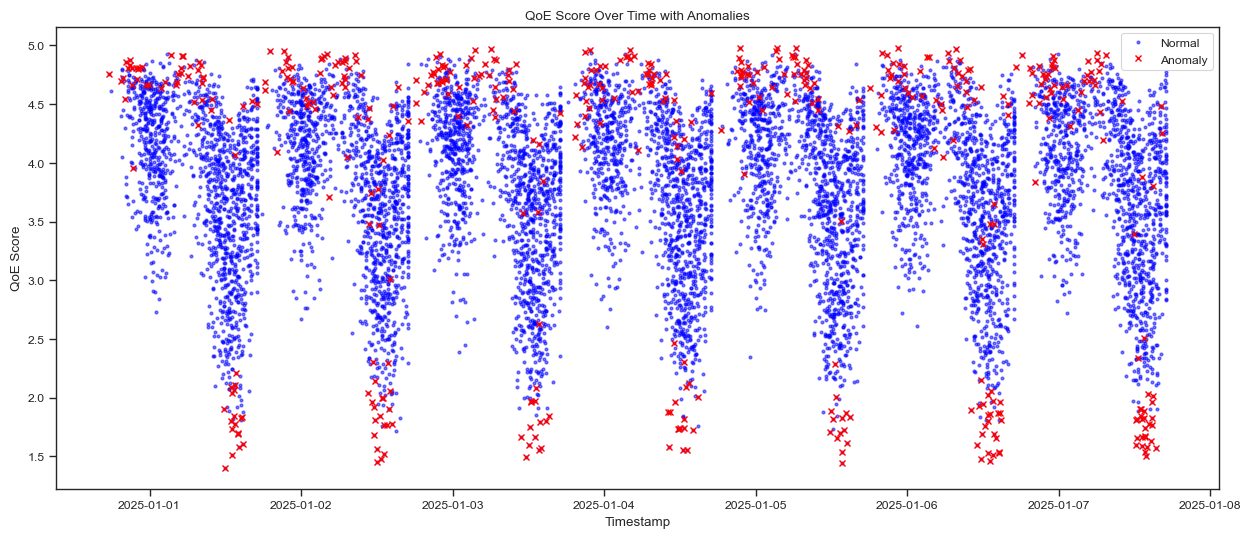

In [4]:
df_viz = df.loc[X.index].copy()
df_viz['is_anomaly'] = anomalies
df_viz = df_viz.sort_values('timestamp_start')

plt.figure(figsize=(15, 6))
# Plot normal points
plt.plot(df_viz['timestamp_start'], df_viz['qoe_score'], 'o', alpha=0.5, label='Normal', color='blue', markersize=2)
# Overlay anomalies
anom = df_viz[df_viz['is_anomaly'] == -1]
plt.plot(anom['timestamp_start'], anom['qoe_score'], 'x', label='Anomaly', color='red', markersize=5)

plt.title("QoE Score Over Time with Anomalies")
plt.xlabel("Timestamp")
plt.ylabel("QoE Score")
plt.legend()
plt.show()

### 💡 How to read this: Time Series Anomalies
* **Clusters:** Do anomalies bunch up at specific times? (e.g., outages).
* **Trend:** Are anomalies associated with dips in QoE? (Validating the model logic).

## 3. Insight: Distribution of Anomalies by Hour

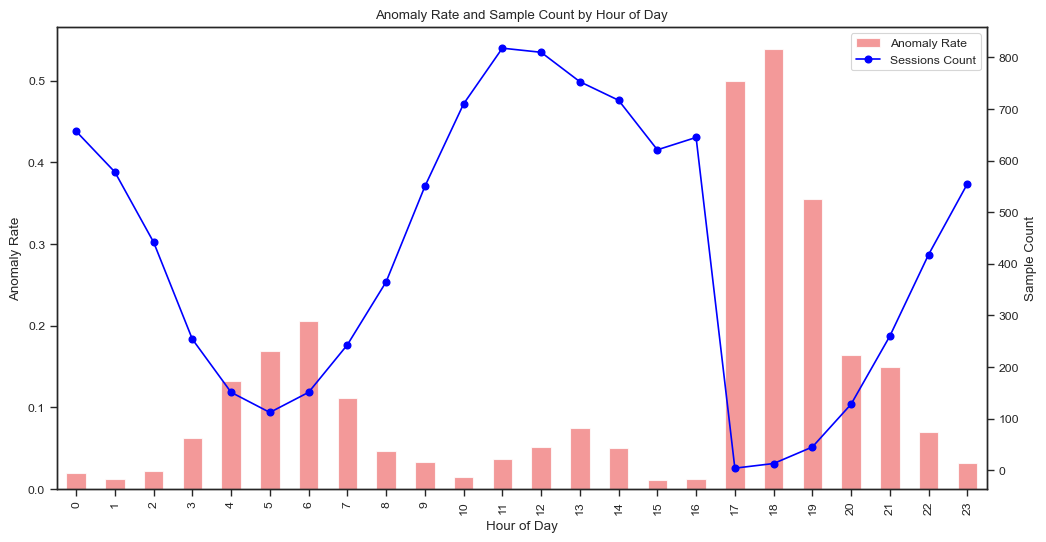

In [5]:
df_sampled = df.loc[X.index].copy()
df_sampled["is_anomaly"] = (anomalies == -1)
df_sampled["hour"] = df_sampled["timestamp_start"].dt.hour

stats = df_sampled.groupby("hour")["is_anomaly"].agg(["mean", "count"])

fig, ax1 = plt.subplots(figsize=(12, 6))

stats["mean"].plot(kind="bar", ax=ax1, color="lightcoral", label="Anomaly Rate", alpha=0.8)
ax1.set_ylabel("Anomaly Rate")
ax1.set_xlabel("Hour of Day")

ax2 = ax1.twinx()
stats["count"].plot(kind="line", ax=ax2, color="blue", marker="o", label="Sessions Count")
ax2.set_ylabel("Sample Count")

plt.title("Anomaly Rate and Sample Count by Hour of Day")
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

### 💡 How to read this: Anomaly Rate by Hour
* **Peaks:** If anomalies peak at 5 PM when traffic is high, it might indicate maintenance activity or hardware failures that go unnoticed during high-traffic times.
